<a href="https://colab.research.google.com/github/Aayushktyagi/Satellite_image_classification/blob/master/Satellite_image_classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [0]:
import parser
import os
import sys
import argparse
import numpy as np

In [0]:
'''
load dataset
split dataset into train and test set
'''
import os
import numpy as np
import scipy.io as sio
import matplotlib.pyplot as plt


class Preprosess(object):
    def __init__(self,datapath):
        self.datapath = datapath

    def load_dataset(self):
        self.data = sio.loadmat(self.datapath)
        self.X_train = self.data['train_x'].transpose()
        self.Y_train = self.data['train_y'].transpose()
        self.X_test = self.data['test_x'].transpose()
        self.Y_test = self.data['test_y'].transpose()
        self.annotation = self.data['annotations']

        self.X_train = self.X_train.reshape(self.X_train.shape[0] , 28, 28, 4)
        self.X_test = self.X_test.reshape(self.X_test.shape[0] , 28, 28, 4)
        #Normalizing data
        self.X_train = self.X_train[:100000] / 255.0
        self.Y_train = self.Y_train[:100000]
        self.X_test = self.X_test /255.0
        return self.X_train,self.Y_train,self.X_test,self.Y_test

    def visualize_data(self):
        if os.path.splitext(os.path.basename(self.datapath))[0] =='sat-4-full':
            labels = ['barren land' , 'trees' , 'grassland','others']
        else:
            labels =['building','barren land','trees','grassland','roads','water']
        per_class_counts_train = np.sum(self.Y_train,axis = 0)
        per_class_counts_test = np.sum(self.Y_test ,axis = 0)
        index = np.arange(len(per_class_counts_train))
        plt.bar(index,per_class_counts_train)
        plt.xlabel("Labels",fontsize = 10)
        plt.ylabel("Count" , fontsize = 10)
        plt.xticks(index , labels , fontsize=10,rotation = 30)
        plt.title("Class wise distribution for train data")
        plt.show()

        #For test data
        index = np.arange(len(per_class_counts_test))
        plt.bar(index,per_class_counts_test)
        plt.xlabel("Labels",fontsize = 10)
        plt.ylabel("Count" , fontsize = 10)
        plt.xticks(index , labels , fontsize=10,rotation = 30)
        plt.title("Class wise distribution for test data")
        plt.show()


In [0]:
'''
convolutional neural network
'''
import os
import tensorflow as tf
from tensorflow.keras.callbacks import Callback
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input , Dense,Conv2D,MaxPooling2D,Dropout,Flatten
import matplotlib.pyplot as plt


class ConvNet(object):
    def __init__(self):
        input_layer = Input(shape=(28,28,4))
        layer_1 = Conv2D(8,(2,2),activation = 'relu',padding = 'same')(input_layer)
        layer_1 = MaxPooling2D((2,2),padding ='same')(layer_1)
        #layer_1 = Dropout(0.3)(layer_1)
        layer_2 = Conv2D(16,(2,2),activation = 'relu',padding = 'same')(layer_1)
        layer_2 = MaxPooling2D((2,2),padding = 'same')(layer_2)
        #layer_2 = Dropout(0.3)(layer_2)
        layer_3 = Conv2D(32,(2,2),activation = 'relu',padding= 'same')(layer_2)
        layer_3 = MaxPooling2D((2,2),padding = 'same')(layer_3)
        #layer_3 = Dropout(0.3)(layer_3)
        layer_flatten = Flatten()(layer_3)
        layer_4 = Dense(784, activation ='relu')(layer_flatten)
        layer_4 = Dropout(0.3)(layer_4)
        output_layer = Dense(4,activation='softmax')(layer_4)

        self._model = Model(input_layer,output_layer)
        self._model.compile(optimizer = 'adam' , loss = 'categorical_crossentropy',metrics = ['accuracy'])
        self._model.summary()

    def train(self, X_train,Y_train,X_test,Y_test,batchsize,epochs,checkpoint_path):

        checkpoint_dir = os.path.dirname(checkpoint_path)
        
        # Create checkpoint callback
        checkpoint_path = checkpoint_path + "cp.ckpt"
        print("checkpoint",checkpoint_path)
        cp_callback = tf.keras.callbacks.ModelCheckpoint(checkpoint_path,
                                            save_weights_only=True,
                                            verbose=1,period=1)
        self._model.fit(X_train,Y_train,
                        batch_size = batchsize,
                        epochs = epochs,
                        validation_data = (X_test,
                                            Y_test),
                        callbacks = [cp_callback])
        
        return self._model
      
    def showloss(self):
        # loss plot
        plt.subplots(figsize=(15,10))
        plt.subplot(2,1,1)
        plt.plot(self._model.history.history['loss'])
        plt.plot(self._model.history.history['val_loss'])
        plt.title('Model loss')
        plt.xlabel('epochs')
        plt.ylabel('loss')
        plt.legend(['Train','Validation'],loc = 'upper left')

        #accuracy plot
        plt.subplot(2,1,2)
        plt.plot(self._model.history.history['acc'])
        plt.plot(self._model.history.history['val_acc'])
        plt.title('Accuracy')
        plt.xlabel('epochs')
        plt.ylabel('accuracy')
        plt.legend(['Train','Validation'] , loc = 'upper left')
        plt.show()


In [0]:
'''
train different models

'''
import numpy as np
import os
import tensorflow as tf
from tensorflow.keras.callbacks import Callback
from tensorflow.keras.models import Model , load_model
from tensorflow.keras.backend import clear_session
from tensorflow.keras.layers import Dense ,Conv2D , Input,Flatten,Dropout
from tensorflow.keras.applications import ResNet50,MobileNet,Xception , DenseNet121
#from ConvNet import ConvNet

def train_model(X_train,Y_train,X_test,Y_test,mode,epochs,batch_size,model_name = None,checkpoint_path=None , model_path = None,):
    clear_session()
    # mode = agrs.mode
    # model_name = args.model_name
    if mode == 'train':
        if model_name == 'ConvNet':
            print("Choosen model ConvNet")
            Convnet = ConvNet()
            model = Convnet.train(X_train,Y_train,X_test,Y_test,batch_size,epochs,checkpoint_path)
#             model.summary()
            Convnet.showloss()
            return model

        else:
          raise ValueError("Select Correct model")


Dataset : Train:(100000, 28, 28, 4):(100000, 4),Test:(100000, 28, 28, 4):(100000, 4)
Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
Instructions for updating:
Use tf.cast instead.
100000/100000 [==============================] - 8s 85us/sample - loss: 0.0586 - acc: 0.9818
Restored model, accuracy: 98.18%


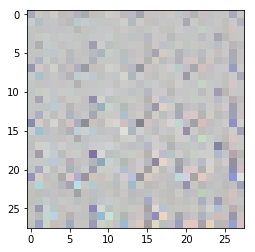

predictions:[0. 1. 0. 0.]: True label:[0 1 0 0]
['trees']
[[25454    13   540   182]
 [    3 20161    12    55]
 [  142   476 17256    72]
 [  110   197    14 35313]]
Classification accuracy :0.98184
Classification report:              precision    recall  f1-score   support

           0       0.99      0.97      0.98     26189
           1       0.97      1.00      0.98     20231
           2       0.97      0.96      0.96     17946
           3       0.99      0.99      0.99     35634

   micro avg       0.98      0.98      0.98    100000
   macro avg       0.98      0.98      0.98    100000
weighted avg       0.98      0.98      0.98    100000



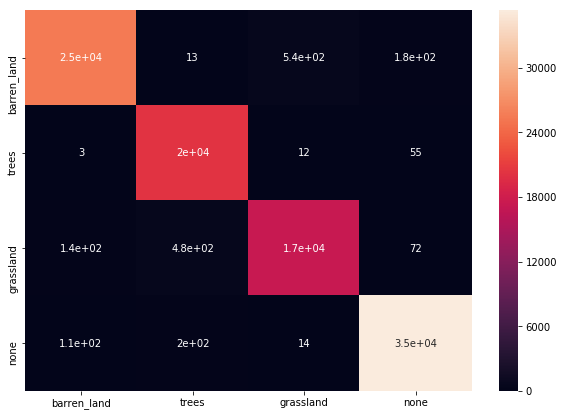

In [0]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report
import seaborn as sn
import pandas as pd

def process(args):
    Prep = Preprosess(args.datapath)
    #load dataset
    X_train , Y_train , X_test , Y_test = Prep.load_dataset()
    print("Dataset : Train:{}:{},Test:{}:{}".format(np.shape(X_train),np.shape(Y_train),np.shape(X_test),np.shape(Y_test)))
    if args.visualize_data == 'True':
        Prep.visualize_data()
    model = train_model(X_train,Y_train,X_test,Y_test,args.mode,args.epochs,args.batch_size,args.model_name,args.output)
    #save model 
    model.save(args.output + 'Sat_classification.h5')

    #load model 
    model = tf.keras.models.load_model(args.output+'Sat_classification.h5')
    latest = tf.train.latest_checkpoint(args.output)
    model.load_weights(latest)
    #calculate accuracy 
    #Test image
    test_images = X_test[50]
    test_labels = Y_test[50]
    loss , acc = model.evaluate(X_test , Y_test)
    print("Restored model, accuracy: {:5.2f}%".format(100*acc))
    
    #Prediction
    categories = ['barren_land','trees','grassland','none']
    #show test images 
    #img=mpimg.imread('your_image.png')
    imgplot = plt.imshow(test_images)
    plt.show()
    test_images = test_images.reshape(1,28,28,4)
    predictions = np.round(model.predict(test_images))[0]
    print("predictions:{}: True label:{}".format(predictions,test_labels))
    labels = [categories[idx] for idx, current_prediction in enumerate(predictions) if current_prediction == 1]
    print(labels)
    
    #confusion metrics
    predictions = model.predict(X_test)
    predict_index = predictions.argmax(axis=1)
    test_index = Y_test.argmax(axis=1)
    results = confusion_matrix(test_index,predict_index)
    print(results)
    df_cm = pd.DataFrame(results, index = [i for i in categories],
                  columns = [i for i in categories])
    plt.figure(figsize = (10,7))
    sn.heatmap(df_cm, annot=True)
    
    #Classification accuracy
    accuracy = accuracy_score(test_index,predict_index)
    print("Classification accuracy :{}".format(accuracy))
    
    #Classification report 
    classify_report = classification_report(test_index,predict_index)
    print("Classification report:{}".format(classify_report))
    
    
if __name__ == "__main__":
    parser = argparse.ArgumentParser()
    parser.add_argument('--datapath',help = 'Path to .mat files',default = 'drive/My Drive/Dataset/Satellite_images/sat-4-full.mat')
    parser.add_argument('--epochs',help = 'Number of epochs',type = int , default = 15)
    parser.add_argument('--visualize_data', help = 'set true to visualize data',default=False)
    parser.add_argument('--mode' , choices = ['train','inference'],default = 'train')
    parser.add_argument('--output' , help= 'path checkpoints will be saved',default='./weights/')
    parser.add_argument('--model_name',choices=['ConvNet','ResNet50','Xception','MobileNet','DenseNet121'],default='ConvNet')
    parser.add_argument('--batch_size',help = 'Select batch size int value',type= int,default=16)
    args = parser.parse_args(args=[])
    process(args)
    
